<a href="https://colab.research.google.com/github/srirampattabiraman/Computer-vision/blob/master/S6/EVA4_S6_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target :

Introduce L1 and L2 on previous code and run for 40 epochs

### Result : - Total params: 9,876


### Analysis : 

Run model for 40 epochs for each:

without L1/L2

with L1

with L2

with L1 and L2


In [0]:
### Model Spec


In [0]:
## Importing the Libraries 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
## Transformation

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
## Data Set - trian test split 

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
## Data Loader arguments : Train Test arguments 

SEED = 5

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1) 
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.03) 
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 4

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.03)
        ) # output_size = 4

        self.avg = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
        ) # output_size = 1
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.avg(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
## Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           2,304
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             720
             ReLU-13           [-1, 10, 10, 10]               0
      BatchNorm2d-14           [-1

Running 40 epochs without L1/L2

In [0]:
# for param in model.parameters():
#   print(param)

In [0]:
### Training

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(40):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.04315751791000366 Batch_id=468 Accuracy=94.05: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9753/10000 (97.53%)

Epoch: 2 LR: 0.1


Loss=0.10068812966346741 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

Epoch: 3 LR: 0.1


Loss=0.05052514001727104 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9892/10000 (98.92%)

Epoch: 4 LR: 0.1


Loss=0.06327027082443237 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9912/10000 (99.12%)

Epoch: 5 LR: 0.1


Loss=0.03712174668908119 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9904/10000 (99.04%)

Epoch: 6 LR: 0.0010000000000000002


Loss=0.022847995162010193 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

Epoch: 7 LR: 0.010000000000000002


Loss=0.012324653565883636 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

Epoch: 8 LR: 0.010000000000000002


Loss=0.01687677763402462 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

Epoch: 9 LR: 0.010000000000000002


Loss=0.013230119831860065 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

Epoch: 10 LR: 0.010000000000000002


Loss=0.03594839572906494 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.007337793707847595 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9947/10000 (99.47%)

Epoch: 12 LR: 0.0010000000000000002


Loss=0.039086196571588516 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

Epoch: 13 LR: 0.0010000000000000002


Loss=0.016490846872329712 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch: 14 LR: 0.0010000000000000002


Loss=0.005205675959587097 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

Epoch: 15 LR: 0.0010000000000000002


Loss=0.021125411614775658 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

Epoch: 16 LR: 1.0000000000000004e-05


Loss=0.05157840624451637 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

Epoch: 17 LR: 0.00010000000000000003


Loss=0.005031377077102661 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

Epoch: 18 LR: 0.00010000000000000003


Loss=0.00661332905292511 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

Epoch: 19 LR: 0.00010000000000000003


Loss=0.04263027384877205 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

Epoch: 20 LR: 0.00010000000000000003


Loss=0.005206415895372629 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

Epoch: 21 LR: 1.0000000000000004e-06


Loss=0.054619189351797104 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

Epoch: 22 LR: 1.0000000000000004e-05


Loss=0.03188584744930267 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Epoch: 23 LR: 1.0000000000000004e-05


Loss=0.009030004031956196 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

Epoch: 24 LR: 1.0000000000000004e-05


Loss=0.03184285759925842 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

Epoch: 25 LR: 1.0000000000000004e-05


Loss=0.021980727091431618 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

Epoch: 26 LR: 1.0000000000000005e-07


Loss=0.043624382466077805 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

Epoch: 27 LR: 1.0000000000000004e-06


Loss=0.05527549609541893 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch: 28 LR: 1.0000000000000004e-06


Loss=0.048783231526613235 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

Epoch: 29 LR: 1.0000000000000004e-06


Loss=0.034103915095329285 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

Epoch: 30 LR: 1.0000000000000004e-06


Loss=0.08093030005693436 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

Epoch: 31 LR: 1.0000000000000005e-08


Loss=0.007001777645200491 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch: 32 LR: 1.0000000000000005e-07


Loss=0.01166002918034792 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)

Epoch: 33 LR: 1.0000000000000005e-07


Loss=0.062065839767456055 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 39.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch: 34 LR: 1.0000000000000005e-07


Loss=0.04478084668517113 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

Epoch: 35 LR: 1.0000000000000005e-07


Loss=0.011815428733825684 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

Epoch: 36 LR: 1.0000000000000005e-09


Loss=0.012639020569622517 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9946/10000 (99.46%)

Epoch: 37 LR: 1.0000000000000005e-08


Loss=0.005879054311662912 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

Epoch: 38 LR: 1.0000000000000005e-08


Loss=0.01979812979698181 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

Epoch: 39 LR: 1.0000000000000005e-08


Loss=0.004059245344251394 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

Epoch: 40 LR: 1.0000000000000005e-08


Loss=0.008029316551983356 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

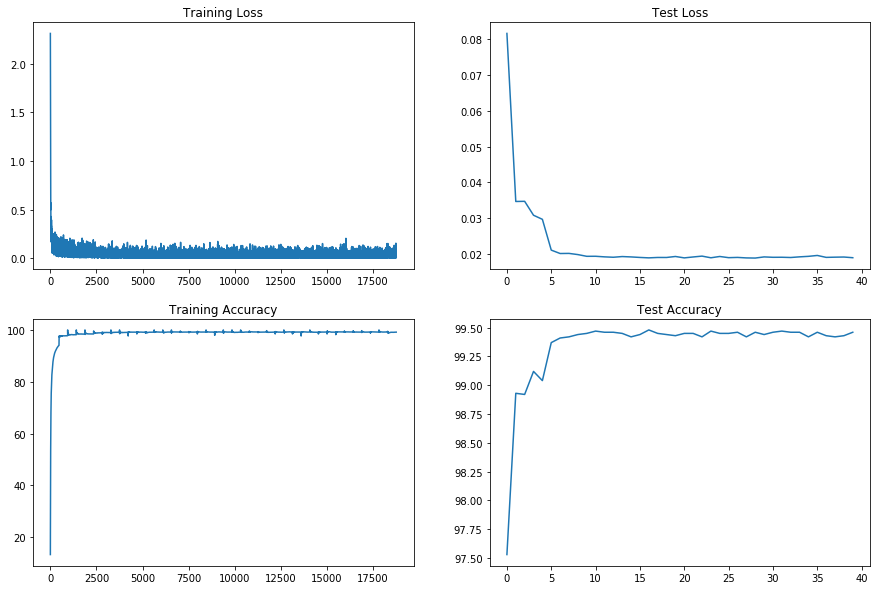

In [10]:
## Plot the accuracy graphs 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Running 40 epochs with L1 regularization

In [11]:
torch.manual_seed(10)
batch_size = 128
LAMBDA=0.0001
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                                                  transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,)),
                                                  transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses_l1 = []
test_losses_l1 = []
train_acc_l1 = []
test_acc_l1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
    loss = loss + L1_3
    #print(l1_reg.shape)
    train_losses_l1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1.append(100*correct/processed)

In [0]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [35]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(40):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.12979626655578613 Batch_id=468 Accuracy=94.28: 100%|██████████| 469/469 [00:16<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9773/10000 (97.73%)

Epoch: 2 LR: 0.1


Loss=0.03333016112446785 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9889/10000 (98.89%)

Epoch: 3 LR: 0.1


Loss=0.04873048886656761 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9879/10000 (98.79%)

Epoch: 4 LR: 0.1


Loss=0.014650367200374603 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9912/10000 (99.12%)

Epoch: 5 LR: 0.1


Loss=0.012953001074492931 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9927/10000 (99.27%)

Epoch: 6 LR: 0.0010000000000000002


Loss=0.016801729798316956 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

Epoch: 7 LR: 0.010000000000000002


Loss=0.05779295414686203 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

Epoch: 8 LR: 0.010000000000000002


Loss=0.09134134650230408 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

Epoch: 9 LR: 0.010000000000000002


Loss=0.059524886310100555 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

Epoch: 10 LR: 0.010000000000000002


Loss=0.011372504755854607 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.01841598004102707 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

Epoch: 12 LR: 0.0010000000000000002


Loss=0.023584695532917976 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

Epoch: 13 LR: 0.0010000000000000002


Loss=0.010556641966104507 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

Epoch: 14 LR: 0.0010000000000000002


Loss=0.03650222346186638 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9950/10000 (99.50%)

Epoch: 15 LR: 0.0010000000000000002


Loss=0.011746002361178398 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

Epoch: 16 LR: 1.0000000000000004e-05


Loss=0.03168538585305214 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

Epoch: 17 LR: 0.00010000000000000003


Loss=0.010365063324570656 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

Epoch: 18 LR: 0.00010000000000000003


Loss=0.032646022737026215 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

Epoch: 19 LR: 0.00010000000000000003


Loss=0.023140989243984222 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

Epoch: 20 LR: 0.00010000000000000003


Loss=0.014797639101743698 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

Epoch: 21 LR: 1.0000000000000004e-06


Loss=0.02280748449265957 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

Epoch: 22 LR: 1.0000000000000004e-05


Loss=0.026893755421042442 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

Epoch: 23 LR: 1.0000000000000004e-05


Loss=0.0235043466091156 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

Epoch: 24 LR: 1.0000000000000004e-05


Loss=0.03650163486599922 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

Epoch: 25 LR: 1.0000000000000004e-05


Loss=0.013364692218601704 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

Epoch: 26 LR: 1.0000000000000005e-07


Loss=0.014586837962269783 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

Epoch: 27 LR: 1.0000000000000004e-06


Loss=0.028993792831897736 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

Epoch: 28 LR: 1.0000000000000004e-06


Loss=0.021996550261974335 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

Epoch: 29 LR: 1.0000000000000004e-06


Loss=0.044512782245874405 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

Epoch: 30 LR: 1.0000000000000004e-06


Loss=0.04053472727537155 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 31 LR: 1.0000000000000005e-08


Loss=0.012905213050544262 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

Epoch: 32 LR: 1.0000000000000005e-07


Loss=0.03844255954027176 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

Epoch: 33 LR: 1.0000000000000005e-07


Loss=0.08367352187633514 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)

Epoch: 34 LR: 1.0000000000000005e-07


Loss=0.01013077050447464 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

Epoch: 35 LR: 1.0000000000000005e-07


Loss=0.016273148357868195 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

Epoch: 36 LR: 1.0000000000000005e-09


Loss=0.009481224231421947 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

Epoch: 37 LR: 1.0000000000000005e-08


Loss=0.008141450583934784 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

Epoch: 38 LR: 1.0000000000000005e-08


Loss=0.07651423662900925 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

Epoch: 39 LR: 1.0000000000000005e-08


Loss=0.014208255335688591 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

Epoch: 40 LR: 1.0000000000000005e-08


Loss=0.02145252376794815 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.02it/s]



Test set: Average loss: 0.0170, Accuracy: 9949/10000 (99.49%)



Text(0.5, 1.0, 'Test Accuracy')

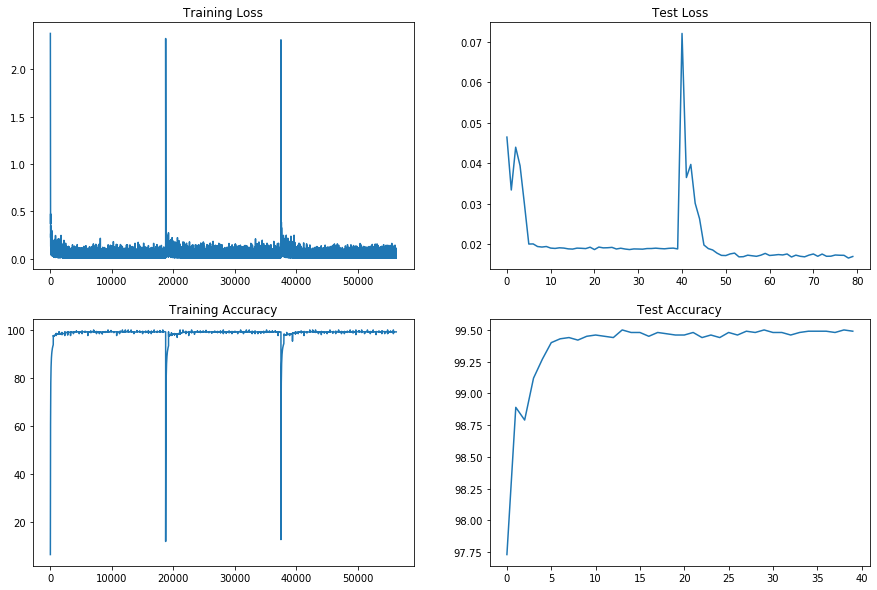

In [36]:
## Plot the accuracy graphs 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_l1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_l1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_l1)
axs[1, 1].set_title("Test Accuracy")

In [0]:
torch.manual_seed(10)
batch_size = 128
LAMBDA=0.0001
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                                                  transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,)),
                                                  transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)

40 epochs with L2 regularization

In [17]:
from tqdm import tqdm

train_losses_l2 = []
test_losses_l2 = []
train_acc_l2 = []
test_acc_l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

from torch.optim.lr_scheduler import StepLR
model_l2 = Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.1, momentum=0.9,nesterov=False, weight_decay=LAMBDA)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(40):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model_l2, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.11015087366104126 Batch_id=468 Accuracy=93.68: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9732/10000 (97.32%)

Epoch: 2 LR: 0.1


Loss=0.05280764400959015 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9863/10000 (98.63%)

Epoch: 3 LR: 0.1


Loss=0.028931042179465294 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9894/10000 (98.94%)

Epoch: 4 LR: 0.0010000000000000002


Loss=0.004277631640434265 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

Epoch: 5 LR: 0.010000000000000002


Loss=0.04733602702617645 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

Epoch: 6 LR: 0.010000000000000002


Loss=0.03893730416893959 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

Epoch: 7 LR: 0.00010000000000000003


Loss=0.05997994542121887 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

Epoch: 8 LR: 0.0010000000000000002


Loss=0.004956056829541922 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.06619825959205627 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

Epoch: 10 LR: 1.0000000000000004e-05


Loss=0.01570338010787964 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.09630820900201797 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

Epoch: 12 LR: 0.00010000000000000003


Loss=0.02196350134909153 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

Epoch: 13 LR: 1.0000000000000004e-06


Loss=0.04240207374095917 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

Epoch: 14 LR: 1.0000000000000004e-05


Loss=0.021420761942863464 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 25.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

Epoch: 15 LR: 1.0000000000000004e-05


Loss=0.004313503857702017 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

Epoch: 16 LR: 1.0000000000000005e-07


Loss=0.019279545173048973 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

Epoch: 17 LR: 1.0000000000000004e-06


Loss=0.09127847105264664 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

Epoch: 18 LR: 1.0000000000000004e-06


Loss=0.03798828646540642 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

Epoch: 19 LR: 1.0000000000000005e-08


Loss=0.022587016224861145 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

Epoch: 20 LR: 1.0000000000000005e-07


Loss=0.002389758825302124 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

Epoch: 21 LR: 1.0000000000000005e-07


Loss=0.028925711289048195 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

Epoch: 22 LR: 1.0000000000000005e-09


Loss=0.03376151993870735 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

Epoch: 23 LR: 1.0000000000000005e-08


Loss=0.006545697804540396 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

Epoch: 24 LR: 1.0000000000000005e-08


Loss=0.03432068973779678 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

Epoch: 25 LR: 1.0000000000000006e-10


Loss=0.030824050307273865 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

Epoch: 26 LR: 1.0000000000000005e-09


Loss=0.10816800594329834 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

Epoch: 27 LR: 1.0000000000000005e-09


Loss=0.04662548378109932 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

Epoch: 28 LR: 1.0000000000000006e-11


Loss=0.08883856981992722 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

Epoch: 29 LR: 1.0000000000000006e-10


Loss=0.032295797020196915 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

Epoch: 30 LR: 1.0000000000000006e-10


Loss=0.009664257057011127 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

Epoch: 31 LR: 1.0000000000000006e-12


Loss=0.06833667308092117 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

Epoch: 32 LR: 1.0000000000000006e-11


Loss=0.05226932838559151 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

Epoch: 33 LR: 1.0000000000000006e-11


Loss=0.03913256153464317 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

Epoch: 34 LR: 1.0000000000000007e-13


Loss=0.05619528889656067 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

Epoch: 35 LR: 1.0000000000000006e-12


Loss=0.009810675866901875 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

Epoch: 36 LR: 1.0000000000000006e-12


Loss=0.03710315749049187 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

Epoch: 37 LR: 1.0000000000000008e-14


Loss=0.019478261470794678 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

Epoch: 38 LR: 1.0000000000000007e-13


Loss=0.009923264384269714 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

Epoch: 39 LR: 1.0000000000000007e-13


Loss=0.06139877438545227 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

Epoch: 40 LR: 1.0000000000000009e-15


Loss=0.029859839007258415 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



40 epochs with both l1 and l2

In [20]:
from tqdm import tqdm

train_losses_l1l2 = []
test_losses_l1l2 = []
train_acc_l1l2 = []
test_acc_l1l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
      L2_1 = Variable(param, requires_grad=True)
      L2_2 = torch.norm(L2_1, 2)
      L2_3 = LAMBDA * L2_2
    loss = loss + L1_3 + L2_3

    train_losses_l1l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

from torch.optim.lr_scheduler import StepLR
model_l1l2 = Net().to(device)
optimizer = optim.SGD(model_l1l2.parameters(), lr=0.1, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(40):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model_l1l2, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_l1l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.060525137931108475 Batch_id=468 Accuracy=93.17: 100%|██████████| 469/469 [00:16<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9842/10000 (98.42%)

Epoch: 2 LR: 0.1


Loss=0.01843181438744068 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9877/10000 (98.77%)

Epoch: 3 LR: 0.1


Loss=0.13361510634422302 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9865/10000 (98.65%)

Epoch: 4 LR: 0.0010000000000000002


Loss=0.02307702600955963 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

Epoch: 5 LR: 0.010000000000000002


Loss=0.02777562104165554 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

Epoch: 6 LR: 0.010000000000000002


Loss=0.02526891976594925 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

Epoch: 7 LR: 0.00010000000000000003


Loss=0.06331582367420197 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

Epoch: 8 LR: 0.0010000000000000002


Loss=0.049323007464408875 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.057710591703653336 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

Epoch: 10 LR: 1.0000000000000004e-05


Loss=0.14599429070949554 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.06097681075334549 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Epoch: 12 LR: 0.00010000000000000003


Loss=0.04439400136470795 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

Epoch: 13 LR: 1.0000000000000004e-06


Loss=0.04638207331299782 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

Epoch: 14 LR: 1.0000000000000004e-05


Loss=0.02623611129820347 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

Epoch: 15 LR: 1.0000000000000004e-05


Loss=0.015394207090139389 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

Epoch: 16 LR: 1.0000000000000005e-07


Loss=0.08492223918437958 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 17 LR: 1.0000000000000004e-06


Loss=0.012891901656985283 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

Epoch: 18 LR: 1.0000000000000004e-06


Loss=0.024428963661193848 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9928/10000 (99.28%)

Epoch: 19 LR: 1.0000000000000005e-08


Loss=0.023703064769506454 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 20 LR: 1.0000000000000005e-07


Loss=0.042747825384140015 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

Epoch: 21 LR: 1.0000000000000005e-07


Loss=0.05574306100606918 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

Epoch: 22 LR: 1.0000000000000005e-09


Loss=0.02630065754055977 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

Epoch: 23 LR: 1.0000000000000005e-08


Loss=0.04093987122178078 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

Epoch: 24 LR: 1.0000000000000005e-08


Loss=0.10402809083461761 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

Epoch: 25 LR: 1.0000000000000006e-10


Loss=0.013632114045321941 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

Epoch: 26 LR: 1.0000000000000005e-09


Loss=0.021277984604239464 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

Epoch: 27 LR: 1.0000000000000005e-09


Loss=0.021681010723114014 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

Epoch: 28 LR: 1.0000000000000006e-11


Loss=0.052695468068122864 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

Epoch: 29 LR: 1.0000000000000006e-10


Loss=0.13365785777568817 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

Epoch: 30 LR: 1.0000000000000006e-10


Loss=0.030904434621334076 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

Epoch: 31 LR: 1.0000000000000006e-12


Loss=0.009943321347236633 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

Epoch: 32 LR: 1.0000000000000006e-11


Loss=0.026509590446949005 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

Epoch: 33 LR: 1.0000000000000006e-11


Loss=0.13725164532661438 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Epoch: 34 LR: 1.0000000000000007e-13


Loss=0.027488773688673973 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 35 LR: 1.0000000000000006e-12


Loss=0.04810883849859238 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

Epoch: 36 LR: 1.0000000000000006e-12


Loss=0.03947325050830841 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

Epoch: 37 LR: 1.0000000000000008e-14


Loss=0.04972562938928604 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

Epoch: 38 LR: 1.0000000000000007e-13


Loss=0.026588693261146545 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

Epoch: 39 LR: 1.0000000000000007e-13


Loss=0.017521372064948082 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:19<00:00, 27.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

Epoch: 40 LR: 1.0000000000000009e-15


Loss=0.014141703955829144 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy L1 and L2')

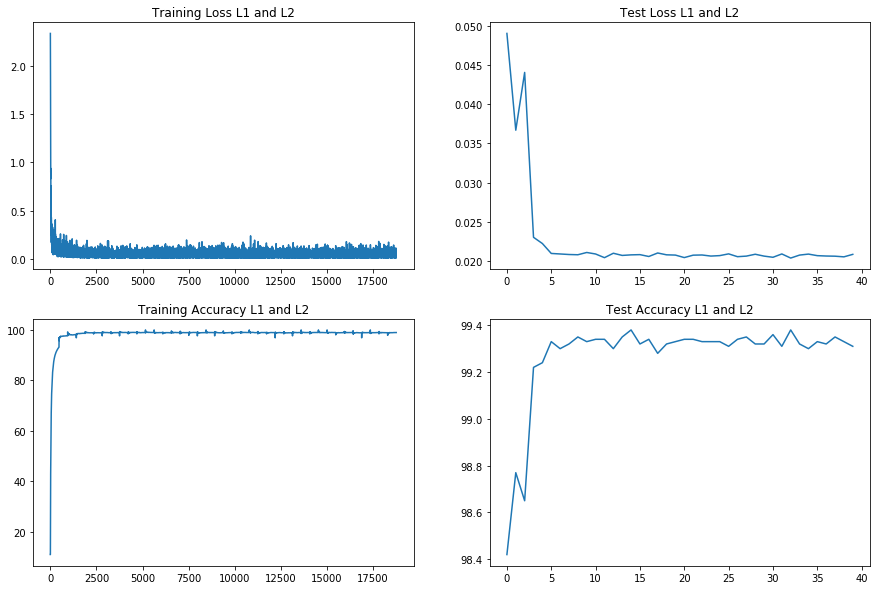

In [22]:
## Plot the accuracy graphs 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l1l2)
axs[0, 0].set_title("Training Loss L1 and L2")
axs[1, 0].plot(train_acc_l1l2)
axs[1, 0].set_title("Training Accuracy L1 and L2")
axs[0, 1].plot(test_losses_l1l2)
axs[0, 1].set_title("Test Loss L1 and L2")
axs[1, 1].plot(test_acc_l1l2)
axs[1, 1].set_title("Test Accuracy L1 and L2")

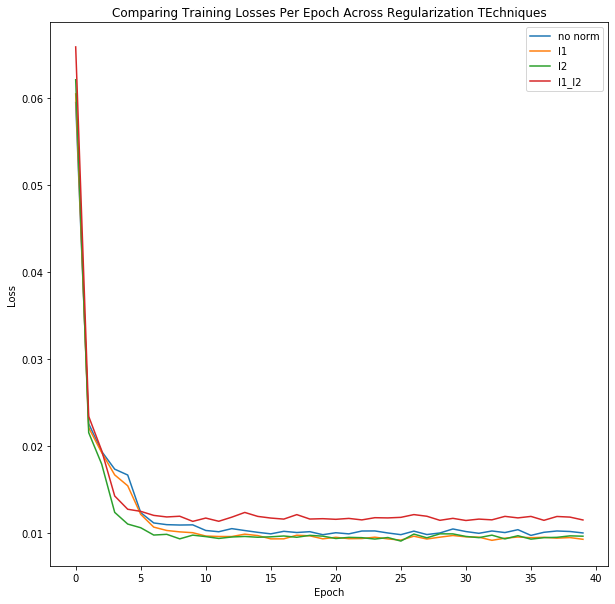

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_losses[i]
  sum2 += train_losses_l1[i]
  sum3 += train_losses_l2[i]
  sum4 += train_losses_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Losses Per Epoch Across Regularization TEchniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no norm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

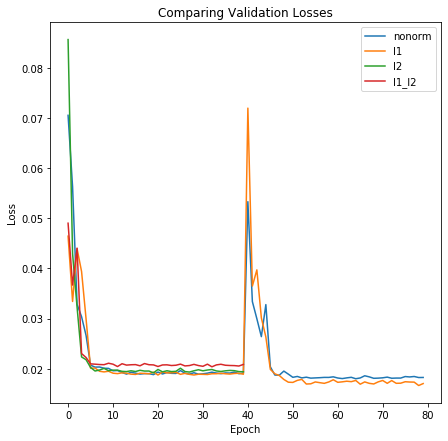

In [45]:
plt.plot(test_losses)
plt.plot(test_losses_l1)
plt.plot(test_losses_l2)
plt.plot(test_losses_l1l2)

plt.title('Comparing Validation Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

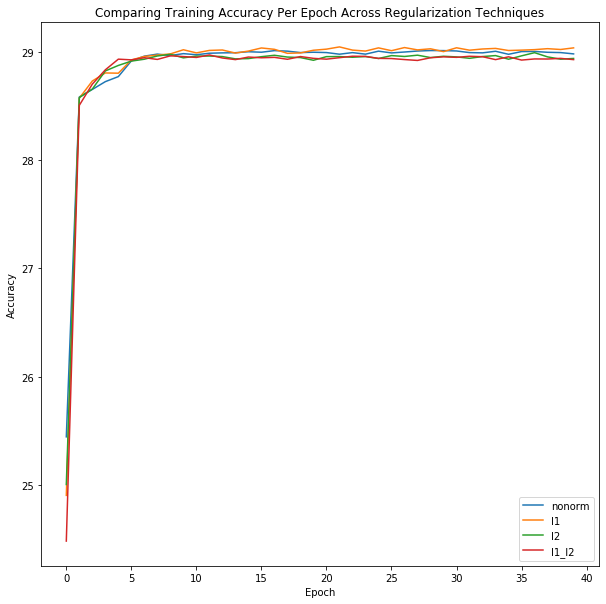

In [39]:
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_acc[i]
  sum2 += train_acc_l1[i]
  sum3 += train_acc_l2[i]
  sum4 += train_acc_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Accuracy Per Epoch Across Regularization Techniques')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

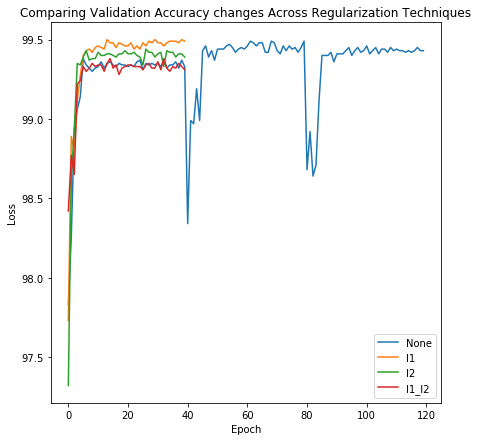

In [44]:
plt.plot(test_acc)
plt.plot(test_acc_l1)
plt.plot(test_acc_l2)
plt.plot(test_acc_l1l2)

plt.title('Comparing Validation Accuracy changes Across Regularization Techniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['None', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

In [0]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result=[]
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l1(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])

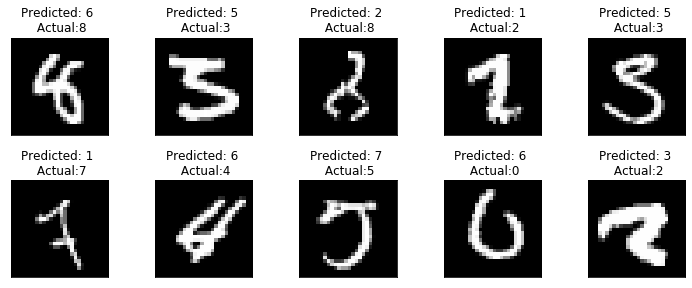

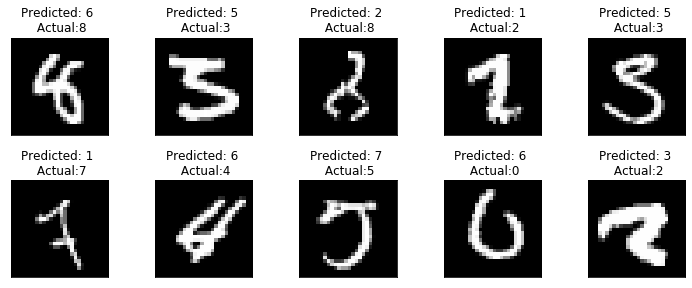

In [46]:
rcParams['figure.figsize'] = 10,10

import matplotlib.pyplot as plt
fig = plt.figure()

data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig

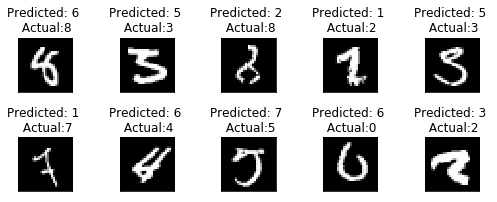

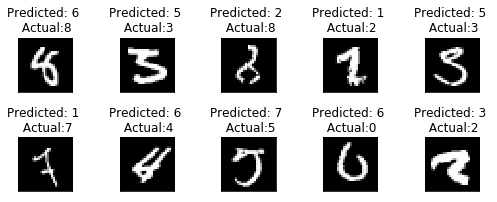

In [43]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result = []
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l2(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])
import matplotlib.pyplot as plt
fig = plt.figure()
data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig